In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [2]:
X_train = torch.load('data/train/train/trainX.pt')
Y_train = torch.load('data/train/train/trainY.pt') 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class DataSet(Dataset):
    def __init__(self, X, Y, angle = 0, color = 0, transform = None):
        self.X = X
        self.Y = Y
        self.angle = angle
        self.color = color
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y[index]
        
        if self.transform:
            X = self.transform(X)
    
        X = torch.unsqueeze(X[self.angle][self.color], 0)
        
        return (X.float(), Y.float())

torch.Size([339, 1, 56, 56])


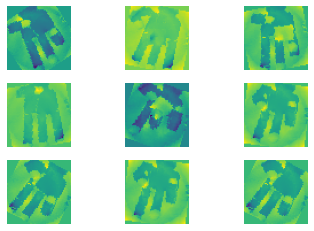

In [6]:
transform = transforms.Compose([transforms.CenterCrop(180),
                                transforms.Resize(56),
                                transforms.Normalize(mean = mean, std = std),
                                transforms.RandomRotation(42)])
dataset = DataSet(X = X_train[0], Y = Y_train[0], transform = transform)
dataloader = DataLoader(dataset,
                        batch_size = len(dataset) // 10,
                        shuffle = True,
                        num_workers = 0)
train_images, train_labels = next(iter(dataloader))

print(train_images.shape)
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(train_images[np.random.choice(len(train_images))][0])
    plt.tight_layout
    plt.axis('off')

In [5]:
mean = torch.mean(train_images, axis = 0)
std = torch.std(train_images, axis = 0)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=5)
        
        self.pool = nn.AvgPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(8 * 3 * 3, 50)
        self.fc2 = nn.Linear(50, 12)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 72)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [8]:
def train(epoch, model, optimizer):
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    
    print('Epoch: ' + str(epoch) + ' Loss: ' + str(loss.item()))

In [9]:
model = CNN() 
model.to(device)
optimizer = optim.Adam(model.parameters())

for epoch in range(0, 10):
    train(epoch, model, optimizer)

Epoch: 0 Loss: 0.0013615358620882034
Epoch: 1 Loss: 0.0006182452198117971
Epoch: 2 Loss: 0.0005146609037183225
Epoch: 3 Loss: 0.00047524471301585436
Epoch: 4 Loss: 0.0004155831993557513
Epoch: 5 Loss: 0.00036580220330506563
Epoch: 6 Loss: 0.00026537812664173543
Epoch: 7 Loss: 0.00031464771018363535
Epoch: 8 Loss: 0.000377492920961231
Epoch: 9 Loss: 0.00023529649479314685


# Submission Code

In [10]:
import pickle
import pandas as pd

outfile = 'submission.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
preds = []

test_data = torch.load('data/test/test/testX.pt')
file_ids = test_data[-1]
rgb_data = test_data[0]
model.eval()

for i, data in enumerate(rgb_data):
    # Please remember to modify this loop, input and output based on your model/architecture
    X = transform(torch.squeeze(test_data[0][:, :1, :1, :], 1))
    output = model(X)
    preds.append(output[0].cpu().detach().numpy())

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file submission.csv
